# Load Data From CSV to Data Frame

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")  
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('AAPL.csv') #apple

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.513393,0.515625,0.513393,0.513393,0.406782,117258400
1,1980-12-15,0.488839,0.488839,0.486607,0.486607,0.385558,43971200
2,1980-12-16,0.453125,0.453125,0.450893,0.450893,0.357260,26432000
3,1980-12-17,0.462054,0.464286,0.462054,0.462054,0.366103,21610400
4,1980-12-18,0.475446,0.477679,0.475446,0.475446,0.376715,18362400


# Scaling The Closing Price Column

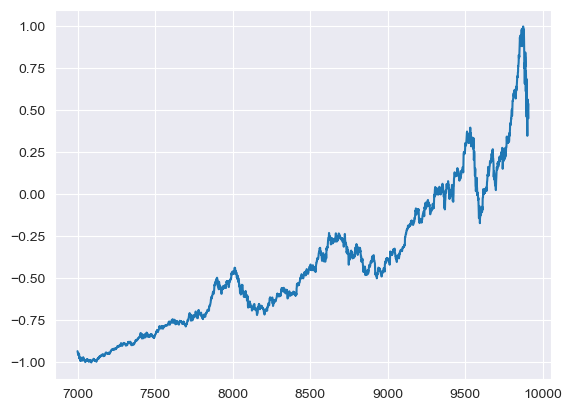

In [2]:
price = df[['Close']]
# price_30p = price[7000:]
# price = price_30p
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))
price
plt.plot(price.index, price)

# Split Data (sliding window)  and Training And Validation

In [3]:
def window(scaled_data, length):
    data_in = scaled_data.to_numpy() 
    data_out = []
    for index in range(len(data_in) - length): 
        data_out.append(data_in[index: index + length])
    
    data_out = np.array(data_out)
    return data_out
def split_data(window_data,ratio):
    
    test_set_size = int(np.round(ratio*window_data.shape[0]))
    train_set_size = window_data.shape[0] - (test_set_size)
    
    x_train = window_data[:train_set_size,:-1,:]
    y_train = window_data[:train_set_size,-1,:]
    x_test = window_data[train_set_size:,:-1]
    y_test = window_data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]



price = window(price,7)
x_train, y_train, x_test, y_test = split_data(price, 0.2)

# Converting Data to Tensors on My GPU

In [4]:
x_train = torch.from_numpy(x_train).type(torch.Tensor).cuda()
x_test = torch.from_numpy(x_test).type(torch.Tensor).cuda()
y_train = torch.from_numpy(y_train).type(torch.Tensor).cuda()
y_test = torch.from_numpy(y_test).type(torch.Tensor).cuda()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# RNN Model

In [5]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.RNN = nn.RNN(input_dim,hidden_dim,num_layers,batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device) 
        out, _ = self.RNN(x, h0)  
        out = out[:, -1, :]
        out = self.fc(out)
        return out

# Parameters , Creating Model Instance, Loss and Optimizer

In [6]:
input_dim = 1
hidden_dim = 64
num_layers = 2
output_dim = 1
num_epochs = 100

model = RNN(input_size=input_dim, hidden_size=hidden_dim, num_classes=output_dim, num_layers=num_layers).to(device)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)


# Training

In [7]:
loss_history = np.zeros(num_epochs)
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train)
    print("Epoch ", t, "Loss: ", loss.item())
    loss_history[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()


Epoch  0 Loss:  0.2524194121360779
Epoch  1 Loss:  0.15512920916080475
Epoch  2 Loss:  0.0900554358959198
Epoch  3 Loss:  0.05994735285639763
Epoch  4 Loss:  0.06535454839468002
Epoch  5 Loss:  0.08410289883613586
Epoch  6 Loss:  0.08795856684446335
Epoch  7 Loss:  0.07749427109956741
Epoch  8 Loss:  0.06346222758293152
Epoch  9 Loss:  0.05329422280192375
Epoch  10 Loss:  0.04917917773127556
Epoch  11 Loss:  0.049788862466812134
Epoch  12 Loss:  0.052436910569667816
Epoch  13 Loss:  0.054669853299856186
Epoch  14 Loss:  0.054992180317640305
Epoch  15 Loss:  0.052997056394815445
Epoch  16 Loss:  0.0490771159529686
Epoch  17 Loss:  0.04411865398287773
Epoch  18 Loss:  0.039218027144670486
Epoch  19 Loss:  0.03543068468570709
Epoch  20 Loss:  0.03344503045082092
Epoch  21 Loss:  0.03311101719737053
Epoch  22 Loss:  0.033164385706186295
Epoch  23 Loss:  0.031788554042577744
Epoch  24 Loss:  0.02805566042661667
Epoch  25 Loss:  0.02271142043173313
Epoch  26 Loss:  0.017548860982060432
Epoch

In [8]:
predict = pd.DataFrame((y_train_pred.cpu().detach().numpy()))
original = pd.DataFrame((y_train.cpu().detach().numpy()))
# predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.cpu().detach().numpy()))
# original = pd.DataFrame(scaler.inverse_transform(y_train.cpu().detach().numpy()))

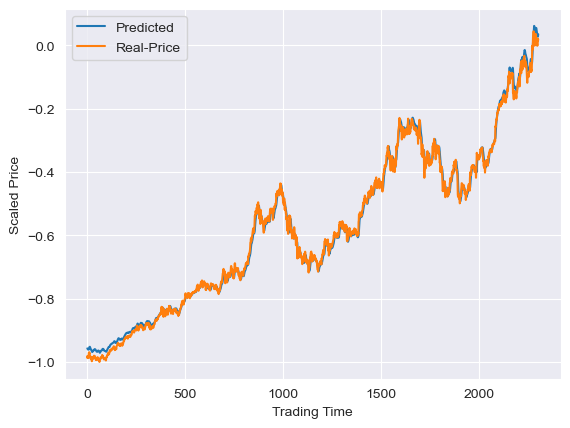

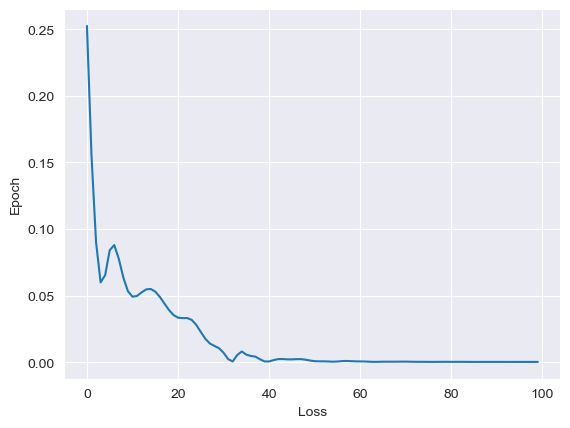

In [9]:

plt.plot(predict.index, predict[0], label = "Predicted")
plt.plot(original.index, original[0], label = "Real-Price")
plt.legend()
plt.xlabel('Trading Time')
plt.ylabel('Scaled Price')
plt.show()
plt.plot(loss_history, label = "Loss")
plt.xlabel('Loss')
plt.ylabel('Epoch')
plt.show()



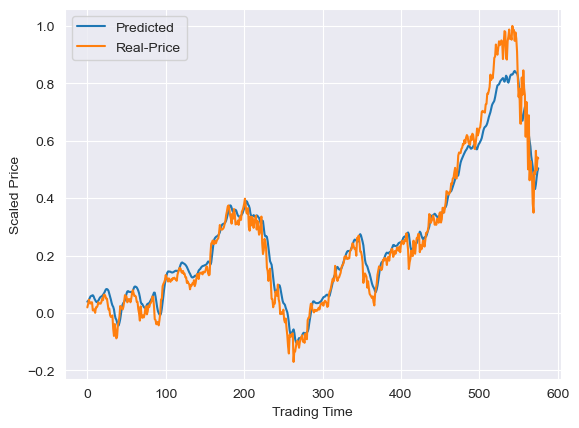

In [10]:
# Model = RNN()
# Model.load_state_dict(torch.load(PATH))
y_test_pred = model(x_test)
validate_predict = pd.DataFrame((y_test_pred.cpu().detach().numpy()))
validate_original = pd.DataFrame((y_test.cpu().detach().numpy()))

# validate_predict = pd.DataFrame(scaler.inverse_transform(y_test_pred.cpu().detach().numpy()))
# validate_original = pd.DataFrame(scaler.inverse_transform(y_test.cpu().detach().numpy()))

plt.plot(validate_predict.index, validate_predict[0], label = "Predicted")
plt.plot(validate_original.index, validate_original[0], label = "Real-Price")
plt.xlabel('Trading Time')
plt.ylabel('Scaled Price')
plt.legend()
plt.show()

In [11]:
import math 
from sklearn.metrics import mean_squared_error

trainScore = math.sqrt(mean_squared_error(original[0], predict[0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(validate_original[0], validate_predict[0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.02 RMSE
Test Score: 0.05 RMSE
